In [ ]:
# Mount Google Drive so the project data files can be accessed from Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
# Path to the project folder inside Google Drive
project_folder_path = '/content/drive/My Drive/Project_C4'

In [ ]:
# Load and prepare TEST dataset
df_test = pd.read_csv("/content/drive/My Drive/Project_C4/df_test.csv")
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.sort_values("date")



In [ ]:
# Load and prepare TRAIN dataset
df_train = pd.read_csv("/content/drive/My Drive/Project_C4/df_train.csv")
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values("date")

In [ ]:
# Prepare train and test datasets for modeling:
# - rename columns to standardized names (ds, y)
df_train = df_train.rename(columns={"date": "ds", "trips": "y"})
df_test  = df_test.rename(columns={"date": "ds", "trips": "y"})
# - convert date strings to datetime
df_train["ds"] = pd.to_datetime(df_train["ds"])
df_test["ds"]  = pd.to_datetime(df_test["ds"])

# - map season labels to numeric codes
seasons = {
    "Winter": 0,
    "Spring": 1,
    "Summer": 2,
    "Fall": 3
}
df_train['season'] = df_train['season'].map(seasons)
df_test['season']  = df_test['season'].map(seasons)

In [ ]:
# - add a split indicator
# - combine train and test into a single unified dataframe ordered by date
df_train["split"] = "train"
df_test["split"] = "test"

df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_all.sort_values("ds").reset_index(drop=True)

In [ ]:
import numpy as np

def add_features(df):
    df = df.copy()

    # Basic time components
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['month'] = df['ds'].dt.month
    df['day_of_year'] = df['ds'].dt.dayofyear

    # Fourier - weekly
    df['week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Fourier - yearly
    df['year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # Weather interactions
    df['rain_x_season'] = df['prcp'] * df['season']
    df['wind_x_season'] = df['wspd'] * df['season']
    df['temp_x_season'] = df['tavg'] * df['season']
    df['temp_x_month'] = df['tavg'] * df['month']

    # Lag
    df['y_lag1']  = df['y'].shift(1)
    df['y_lag7']  = df['y'].shift(7)
    df['y_lag30'] = df['y'].shift(30)
    df['y_lag90'] = df['y'].shift(90)


    return df

In [ ]:
# Convert selected columns to numeric, generate all model features
num_cols = ["tavg", "prcp", "wspd", "is_weekend", "season", "day_of_week"]

for c in num_cols:
    df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

In [ ]:
# drop rows with missing values, and split the full dataset into
# training and test subsets based on the 'split' flag.
df_all = add_features(df_all)
df_all = df_all.dropna()


train = df_all[df_all["split"] == "train"].copy()
test = df_all[df_all["split"] == "test"].copy()

In [ ]:
from prophet import Prophet

# Select the feature columns (regressors)
regressors = [
    'day_of_week', 'month', 'day_of_year',
    'week_sin', 'week_cos',
    'year_sin', 'year_cos',
    'rain_x_season', 'wind_x_season',
    'temp_x_season', 'temp_x_month',
    'tavg', 'prcp', 'wspd', 'season',
    'y_lag1', 'y_lag7', 'y_lag30', 'y_lag90'
]


m = Prophet(
    weekly_seasonality=False,
    yearly_seasonality=False,
    daily_seasonality=False
)

for r in regressors:
    m.add_regressor(r)


In [ ]:
# Fit the Prophet model on the training data using all selected regressors,
m.fit(train[['ds', 'y'] + regressors])

In [ ]:
# generate predictions for the test period, and merge the forecasted values
# (yhat, yhat_lower, yhat_upper) back into the test dataset.
future_test = test[['ds'] + regressors]

forecast = m.predict(future_test)

test = test.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left'
)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Metrics
test_clean = test.dropna(subset=['yhat'])

mae = mean_absolute_error(test_clean['y'], test_clean['yhat'])
rmse = mean_squared_error(test_clean['y'], test_clean['yhat']) ** 0.5
r2 = r2_score(test_clean['y'], test_clean['yhat'])

print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²  :", round(r2, 4))



MAE : 13377.5879
RMSE: 16792.734
R²  : 0.7563


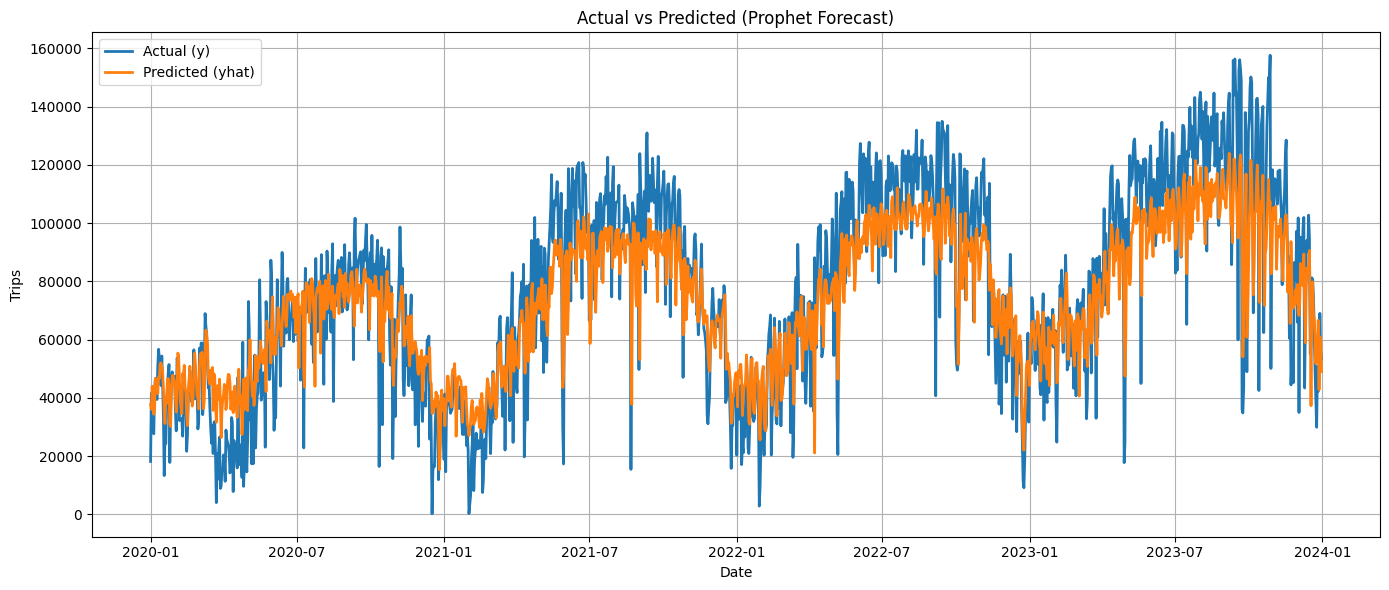

In [ ]:
import matplotlib.pyplot as plt
# Plot: Actual vs Predicted
plt.figure(figsize=(14,6))

plt.plot(test_clean['ds'], test_clean['y'], label="Actual (y)", linewidth=2)
plt.plot(test_clean['ds'], test_clean['yhat'], label="Predicted (yhat)", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Trips")
plt.title("Actual vs Predicted (Prophet Forecast)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
